In [243]:
# Внимание, сначала первым делом тебе нужно будет прописать функцию install.packages('...')
# Вместо трех точек пишешь название всех библиотек, что используются, например, install.packages('readxl')

In [2]:
library(readxl) # Библиотека для чтения ексель-файлов

Warning message:
"package 'readxl' was built under R version 3.6.3"


In [15]:
library(xts) # Библиотека для работы со временным рядом

Warning message:
"package 'xts' was built under R version 3.6.3"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 3.6.3"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




In [16]:
library(tseries) # Библиотека для теста Дики-Фуллера

Warning message:
"package 'tseries' was built under R version 3.6.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [92]:
library(forecast) # Библиотека для ARIMA

Warning message:
"package 'forecast' was built under R version 3.6.3"


In [239]:
library(openxlsx) # Библиотека для скачивания файлов в Excel формате к себе на компьютер 

Warning message:
"package 'openxlsx' was built under R version 3.6.3"


In [38]:
to_xts <- function(df, ...){ # Функция для перевода фрейма во временной ряд 
    df <- as.data.frame(df)  
    #df$date = as.Date(df$date)
    ts = xts(df[,-1], order.by = df[,1])
    return(ts) 
}

In [45]:
GDP <- read_excel('Downloads/GDP_1980-2018_mezzogiorno.xlsx') # подгружаю файлик с данными 

In [46]:
head(GDP) # посмотрел первые наблюдения 

year,GDP
<chr>,<dbl>
1980,47867.86
1981,57576.73
1982,68491.17
1983,81739.43
1984,93972.64
1985,104683.33


In [47]:
GDP$year <- paste0(GDP$year,'-12-31') # R не видит один год как дату, поэтому добавляю 12 месяц и 31 день

In [48]:
colnames(GDP) <- c('Date', 'Value') # Переименовал столбцы для личного удобства

In [49]:
GDP$Date <- as.Date(GDP$Date) # Делаю столбец с датой - датой

In [50]:
GDP <- to_xts(GDP) # Делаю из таблицы временной ряд

In [52]:
colnames(GDP) <- 'GDP'

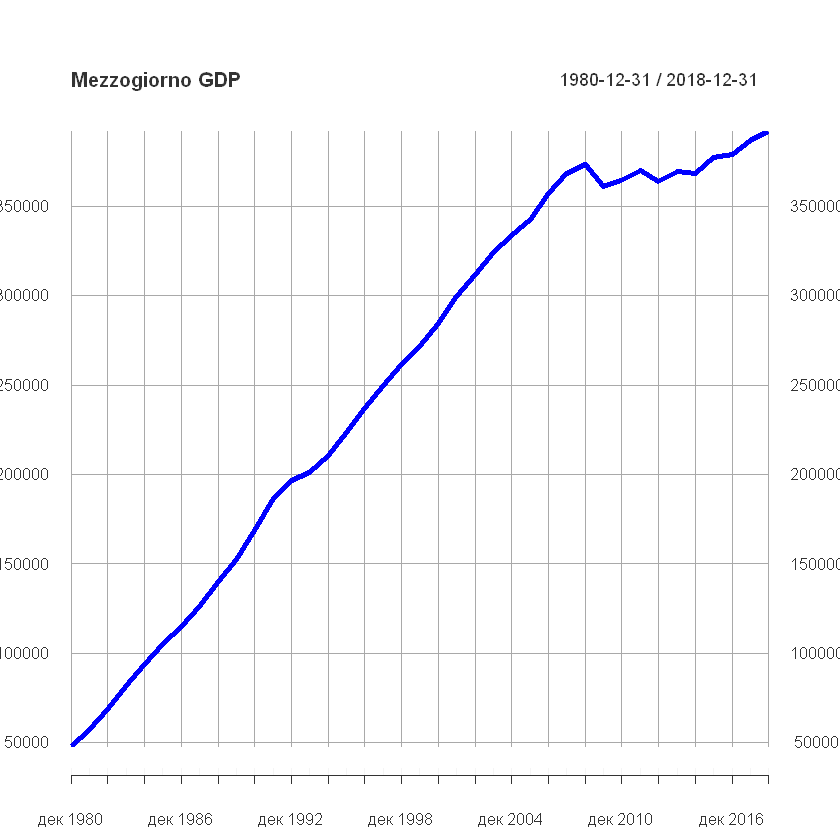

In [244]:
plot(GDP, main = 'Mezzogiorno GDP', col = 'blue', lwd = 4)

In [136]:
adf.test(GDP) # Нестационарный ряд, потому что есть тренд 


	Augmented Dickey-Fuller Test

data:  GDP
Dickey-Fuller = -0.44851, Lag order = 3, p-value = 0.979
alternative hypothesis: stationary


In [137]:
adf.test(diff(log(GDP), 1,)[-1,]) # Первые разности логарифмов не помогают, попробуем что-то другое


	Augmented Dickey-Fuller Test

data:  diff(log(GDP), 1, )[-1, ]
Dickey-Fuller = -2.8848, Lag order = 3, p-value = 0.2275
alternative hypothesis: stationary


In [87]:
adf.test(diff(diff(log(GDP), 1,))[-c(1:2),]) # Разности разностей логарифмов подходят 

Warning message in adf.test(diff(diff(log(GDP), 1, ))[-c(1:2), ]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  diff(diff(log(GDP), 1, ))[-c(1:2), ]
Dickey-Fuller = -4.4732, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


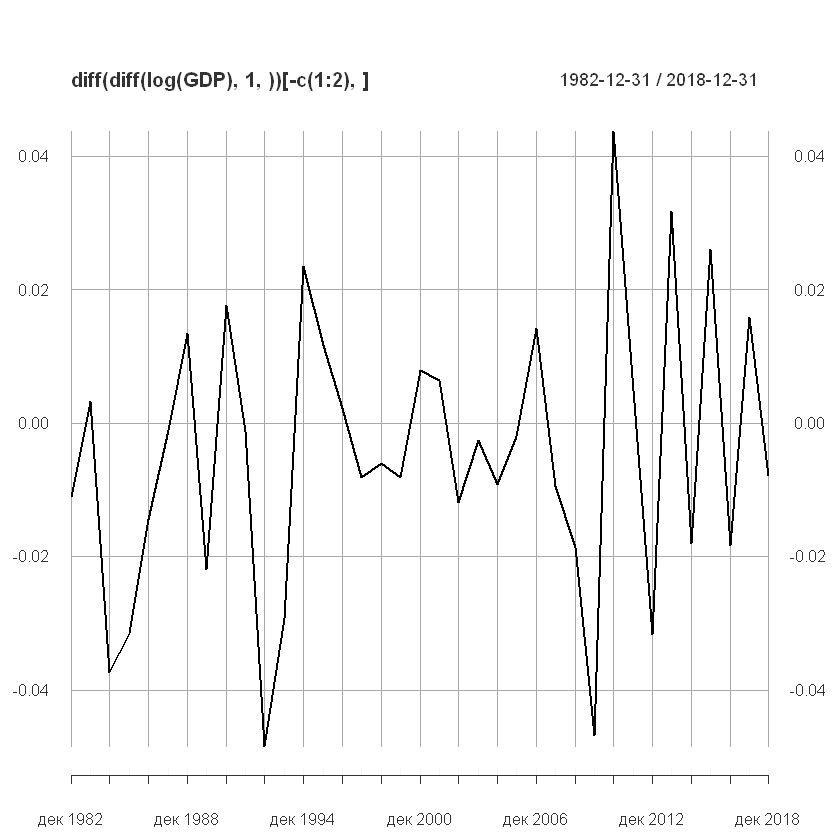

In [89]:
plot(diff(diff(log(GDP), 1,))[-c(1:2),]) # Похоже на правду, далее будем работать только с этим рядом 

In [90]:
GDP.rtn <- diff(diff(log(GDP), 1,))[-c(1:2),] # Создаю новую переменную

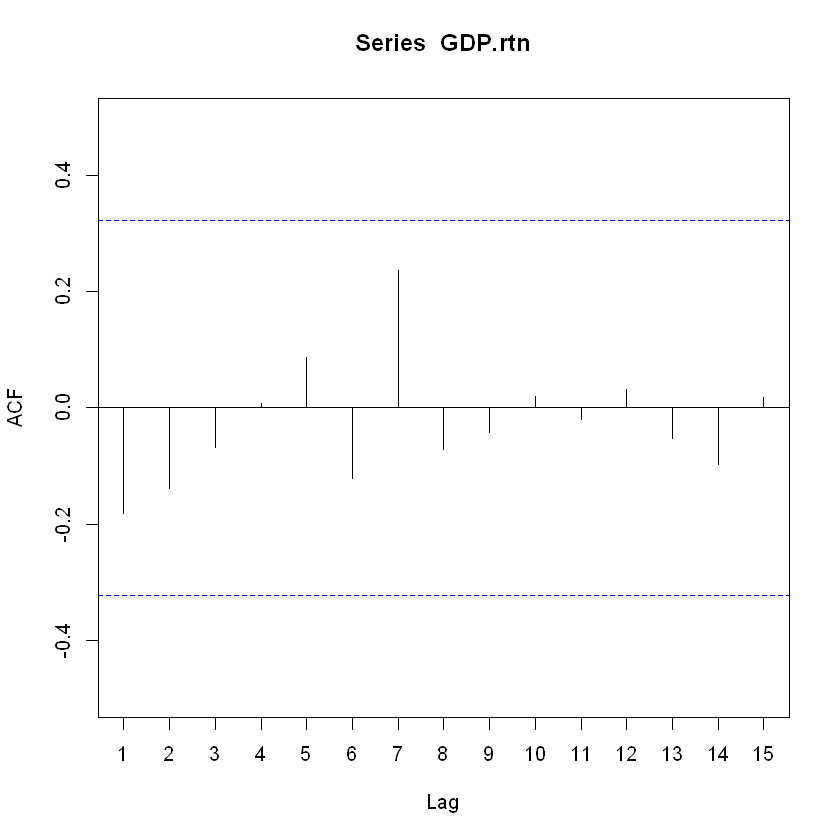

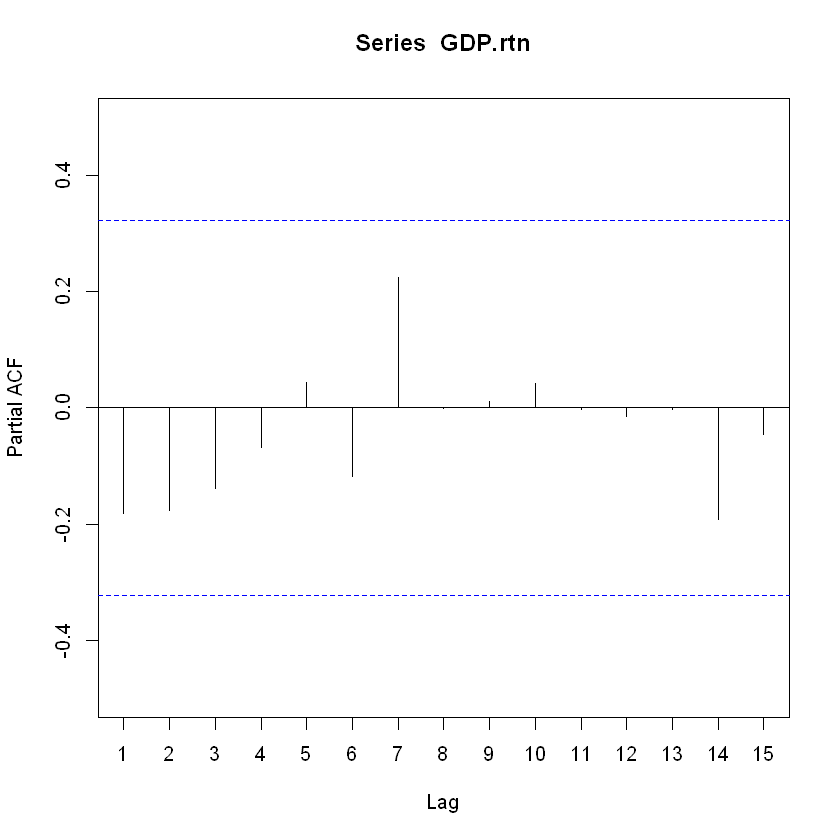

In [150]:
Acf(GDP.rtn) # ACF график
Pacf(GDP.rtn) # PACF график
# Показывает, что никакой автокорреляции нет, поэтому модели будут не очень

In [113]:
auto.arima(GDP.rtn, trace = TRUE, ic = 'aic') # Показывает, что все модели очень плохие, выбирает (0,0,0) с нулевым средним


 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : -178.193
 ARIMA(1,0,0) with non-zero mean : -177.3943
 ARIMA(0,0,1) with non-zero mean : -178.0694
 ARIMA(0,0,0) with zero mean     : -178.3642
 ARIMA(1,0,1) with non-zero mean : Inf

 Best model: ARIMA(0,0,0) with zero mean     



Series: GDP.rtn 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 0.0004472:  log likelihood=90.18
AIC=-178.36   AICc=-178.25   BIC=-176.75

In [118]:
auto.arima(GDP.rtn, trace = TRUE, ic = 'bic') # По BIC то же самое, из-за того что ряд - почти арифметическая прогрессия


 ARIMA(2,0,2) with non-zero mean : Inf
 ARIMA(0,0,0) with non-zero mean : -174.9712
 ARIMA(1,0,0) with non-zero mean : -172.5615
 ARIMA(0,0,1) with non-zero mean : -173.2367
 ARIMA(0,0,0) with zero mean     : -176.7533
 ARIMA(1,0,1) with non-zero mean : Inf

 Best model: ARIMA(0,0,0) with zero mean     



Series: GDP.rtn 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 0.0004472:  log likelihood=90.18
AIC=-178.36   AICc=-178.25   BIC=-176.75

In [155]:
m1 <- Arima(y = GDP.rtn, order = c(0,0,0), include.mean = FALSE) # Строим, как есть 

In [156]:
summary(m1) # Характеристики модели

Series: GDP.rtn 
ARIMA(0,0,0) with zero mean 

sigma^2 estimated as 0.0004472:  log likelihood=90.18
AIC=-178.36   AICc=-178.25   BIC=-176.75

Training set error measures:
                      ME       RMSE        MAE MPE MAPE      MASE       ACF1
Training set -0.00464377 0.02114625 0.01669281 100  100 0.6557996 -0.1807802


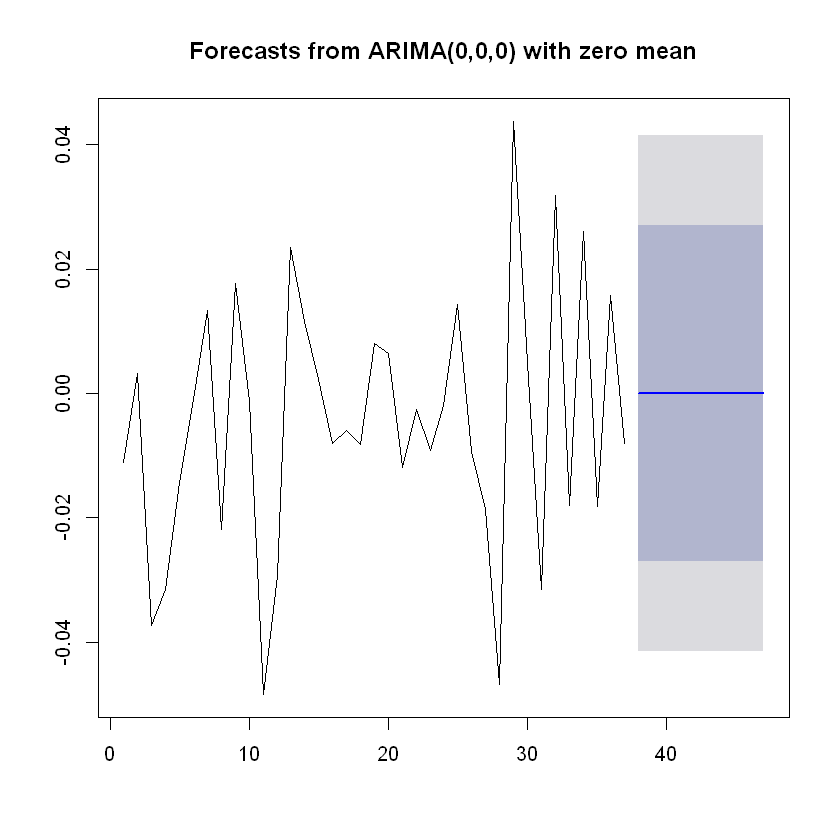

In [217]:
plot(forecast(m1)) # вот эта голубо-серая штука - доверительный интервал, значит, прогноз очень "неуверенный"

In [220]:
forecast(m1, h = 33) # Весь прогноз у нас исключительно нолики

   Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
38              0 -0.02710001 0.02710001 -0.04144589 0.04144589
39              0 -0.02710001 0.02710001 -0.04144589 0.04144589
40              0 -0.02710001 0.02710001 -0.04144589 0.04144589
41              0 -0.02710001 0.02710001 -0.04144589 0.04144589
42              0 -0.02710001 0.02710001 -0.04144589 0.04144589
43              0 -0.02710001 0.02710001 -0.04144589 0.04144589
44              0 -0.02710001 0.02710001 -0.04144589 0.04144589
45              0 -0.02710001 0.02710001 -0.04144589 0.04144589
46              0 -0.02710001 0.02710001 -0.04144589 0.04144589
47              0 -0.02710001 0.02710001 -0.04144589 0.04144589
48              0 -0.02710001 0.02710001 -0.04144589 0.04144589
49              0 -0.02710001 0.02710001 -0.04144589 0.04144589
50              0 -0.02710001 0.02710001 -0.04144589 0.04144589
51              0 -0.02710001 0.02710001 -0.04144589 0.04144589
52              0 -0.02710001 0.02710001

In [221]:
fcst <- forecast(m1, h = 32) # создаем отдельную переменную куда запишем прогноз

In [222]:
fcst$mean

A Time Series:
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [223]:
head(as.data.frame(fcst$mean)) # преобразуем в таблицу

,x
,<dbl>
1,0
2,0
3,0
4,0
5,0
6,0


In [224]:
Dates <- NULL # создаю таблицу с датами, прогноз же до 2050
Dates <- as.data.frame(Dates)
for (i in 1:32){
    Dates[i,1] <- paste0(2018+i, '-12-31')
}
Dates$V1 <- as.Date(Dates$V1)

In [225]:
fcst <- cbind(Dates$V1, as.data.frame(fcst$mean)) # Объединяю даты и прогноз в одну таблицу 

In [226]:
fcst <- to_xts(fcst) # Делаю эту таблицу по формату временным рядом

In [227]:
prediction <- rbind(GDP.rtn, fcst) # Объединяю реальные значения и прогноз

In [228]:
prediction <- rbind(diff(log(GDP), 1)[2,], prediction) 
# Теперь от разности разностей логарифмов нужно придти просто к разности логарифом

In [229]:
for (i in 2:70) { # Возвращаюсь к разности логарифмов
    prediction[i] <-  as.numeric(prediction[i-1]) +  as.numeric(prediction[i])
}

In [230]:
prediction <- rbind(GDP[1], prediction)
# Теперь от разности  логарифмов нужно придти к нормальному виду

In [231]:
for (i in 2:71) {
    prediction[i] <- exp(prediction[i]) * as.numeric(prediction[i-1])
}

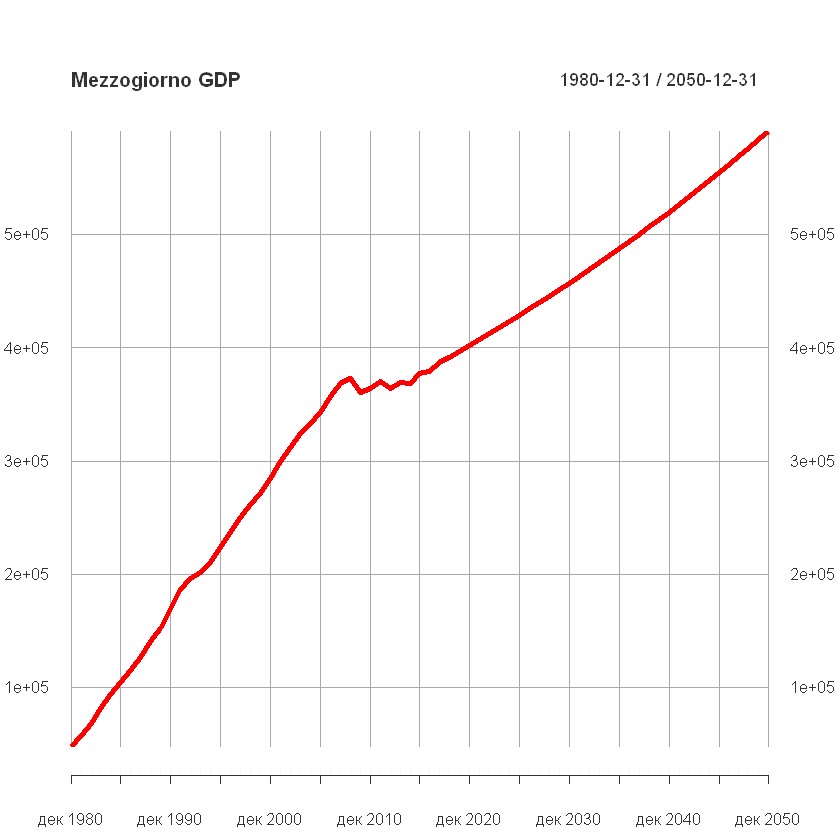

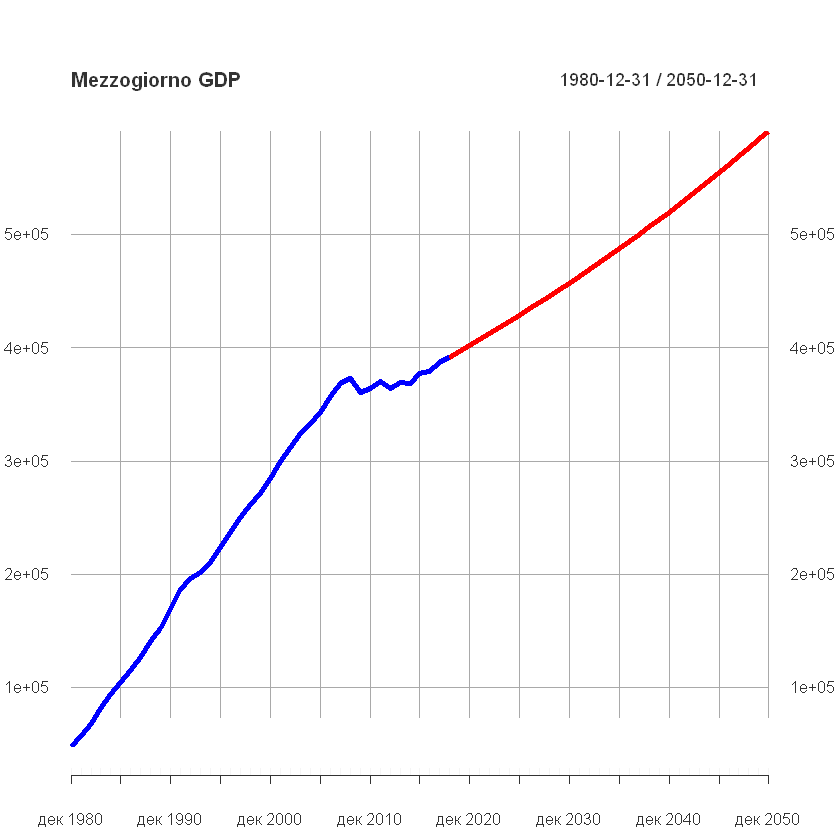

In [232]:
plot(prediction, main = 'Mezzogiorno GDP', col = 'red', lwd = 4)
lines(prediction[1:39], col = 'blue', lwd = 4)
# R криво рисует графики временных рядов, поэтому можно их бахнуть в Экселе или где тебе удобнее

In [242]:
write.xlsx(prediction, 'for_Polina.xlsx') # В файлике не будет годов, сможешь вручную проставить?